In [1]:
import numpy as np
import math
from scipy import integrate
import matplotlib.pyplot as plt
import random
import time 
from scipy.stats import rankdata
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV
from sklearn.datasets import make_sparse_coded_signal
from scipy.stats import bernoulli

In [2]:
N = 500
M = 5000
a = np.zeros(M)
b = np.zeros(M)
m = np.zeros(M)
n = np.zeros(M)

for i in range(M-10):
    m[i] = np.random.binomial(N, 1/3)
    n[i] = np.random.binomial(N-m[i], 1/2)
    a[i] = np.random.binomial(m[i], 1/2)
    b[i] = np.random.binomial(n[i], 1/2)

for i in range(M-10,M):
    m[i] = np.random.binomial(N, 1/3)
    n[i] = np.random.binomial(N-m[i], 1/2)
    a[i] = np.random.binomial(m[i], 2/3)
    b[i] = np.random.binomial(n[i], 2/3)

stats = np.zeros(M)
order = np.zeros(M)

for i in range(M):
    order[i] = i
    if m[i] == 0:
        f = 0
    else:
        f = (2*a[i]-m[i])**2/m[i]
    if n[i] == 0:
        s = 0
    else:
        s = (2*b[i]-n[i])**2/n[i]
    if m[i] + n[i] == N:
        t = 0
    else:
        t = (2*a[i]+2*b[i]-m[i]-n[i])**2/(N-m[i]-n[i])
    
    stats[i] = f + s + t

x = np.argsort(stats)
#for i in range(10):
#    print(x[M-1-i])

stats = sorted(stats, reverse=True)
#print(sorted_stats)

In [3]:
def HaarMatrix(N):
    A = np.zeros((N,N))
    for j in range(0,N):
        A[0,j] = 1/np.sqrt(N)
    for i in range(1,N):
        for j in range(0,N):
            if N*(i-2**(np.floor(math.log2(i))))/(2**(np.floor(math.log2(i)))) <= j and j < N*(i-2**(np.floor(math.log2(i))) + 1/2)/(2**(np.floor(math.log2(i)))):
                A[i,j] = 2**(np.floor(math.log2(i))/2)/np.sqrt(N)
            elif N*(i-2**(np.floor(math.log2(i))) + 1/2)/(2**(np.floor(math.log2(i)))) <= j and j < N*(i-2**(np.floor(math.log2(i))) + 1)/(2**(np.floor(math.log2(i)))):
                A[i,j] = -2**(np.floor(math.log2(i))/2)/np.sqrt(N)
    return A

In [4]:
def BernoulliMatrix(K,N):
    phi = np.zeros((K,N))
    
    for i in range(K):
        for j in range(N):
            phi[i][j] = bernoulli.rvs(0.5, size=1)

    return (phi - 1/2) / (np.sqrt(K) / 2)

In [5]:
def OMP(A, y, N, K):
    x = np.zeros(N)
    S = np.zeros(N, dtype = np.uint8)
    r = y
    rr = np.dot(r,r)
    
    for i in range(K):
        err = rr - np.dot(A[:,S == 0].T, r) ** 2
        ndx = np.where(S == 0)[0]
        S[ndx[err.argmin()]] = 1
        
        As = A[:, S == 1]
        pinv = np.linalg.pinv(np.dot(As, As.T))
        x[S==1] = np.dot(As.T, np.dot(pinv, y))
        
        r = y - np.dot(A, x)
        rr = np.dot(r,r)
    
    return x

def OMPCL(A, y, N, K):
    x = np.zeros(N)
    S = np.zeros(N, dtype = np.uint8)
    
    for i in range(K):
        for j in range(K):
            S[j] = 1
        
        As = A[:, S == 1]
        pinv = np.linalg.pinv(np.dot(As, As.T))
        x[S==1] = np.dot(As.T, np.dot(pinv, y))
    
    return x

In [6]:
def determineS(n,d,psi,eta):
    xx = np.dot(psi.T, d)
    
    s = 0
    for i in range(n):
        if xx[i] > eta:
            s += 1
    
    if s == 0:
        s = 10
    
    return s

In [7]:
def CompressiveMechanism(g, deltag, K, epsilon, eta, phiphi, psi, AA, ss, kk):
    m = np.size(g)
    n = int(2**(np.ceil(math.log2(m))))
    
    d = np.zeros(n)
    for i in range(m):
        d[i] = g[i]
    
    y = np.dot(phiphi, d)
    pri_y = y + np.random.laplace(loc = 0.0, scale = 2*K*deltag*np.sqrt(kk)/epsilon, size=kk)
    
    pri_x = OMP(AA, pri_y, n, ss)
    
    pri_d = np.dot(psi, pri_x)
    pri_g = np.zeros(m)
    for i in range(m):
        pri_g = pri_d
    
    return pri_g

In [8]:
def CompLaplace(g, deltag, s, K, epsilon, phi, psi, A, k):
    m = np.size(g)
    n = int(2**(np.ceil(math.log2(m))))
    
    t = g[int(s)-1]
    
    x = np.zeros(n)
    for i in range(n):
        if i < m and g[i] >= t:
            x[i] = g[i]
        else:
            x[i] = 0
    
    y = np.dot(A, x)
    
    noise = (2*K/epsilon)*np.sqrt(k)*deltag*((1+(np.sqrt(n)-1)*(np.sqrt(2)+1))/np.sqrt(n))
    pri_y = y + np.random.laplace(loc = 0.0, scale = noise, size = k)
    
    pri_x = OMPCL(A, pri_y, n, s)
    
    pri_g = g + np.random.laplace(loc = 0.0, scale = 2*K*deltag/epsilon, size=m)
    
    for i in range(m):
        if g[i] >= t:
            pri_g[i] = pri_x[i]
    
    return pri_g

In [9]:
def lap_noise_normal(data, K, epsilon):
    pri_data = data + np.random.laplace(loc = 0.0, scale = 2*K*(4*N/(N+2))/epsilon, size=np.size(data))
    
    return pri_data

In [10]:
def random_num(pd):
    dist = np.cumsum(pd).tolist()
    dist[-1] = 1.0
    num = np.random.rand()
    dist.append(num)
    return sorted(dist).index(num)

def exp_mec(stats, s, m, K, epsilon):
    h = np.zeros(m)
    for i in range(m):
        h[i] = stats[i]
    S = np.zeros(K)
    k = 0
    
    w = np.zeros(m)
    p = np.zeros(m)
    
    while k < K:
        sumw = 0
        for i in range(m):
            w[i] = math.exp(epsilon * h[i] / (2*K*s))
            sumw += w[i]
        for i in range(m):
            p[i] = w[i]/sumw
            
        x = random_num(p)
        h[x] = -1000000.0
        S[k] = x
        k += 1
    
    return S

In [11]:
def calc_RE(pri_data, K, M):
    RE = 0
    pri_rank = rankdata(-pri_data)
    for i in range(K):
        for j in range(M):
            if pri_rank[j] == i + 1:
                RE += math.fabs(j-i)
                break
    RE /= K
    return RE

In [12]:
def calc_RE_exp(pri_data, K):
    RE = 0
    for i in range(K):
        RE += math.fabs(pri_data[i] - i)
    RE /= K
    return RE

In [13]:
def RankError(g, deltag, K, epsilon,eta, s, m, phi, phiphi, psi, A, AA, ss, k, kk):
    RE = np.zeros(4)
    for j in range(10):
        pri_comp_data = CompressiveMechanism(g, deltag, K, epsilon,eta, phiphi, psi, AA, ss, kk)
        RE[0] += calc_RE(pri_comp_data, K, m)
        
        pri_complap_data = CompLaplace(g, deltag, s, K, epsilon, phi, psi, A, k)
        RE[1] += calc_RE(pri_complap_data, K, m)
        
        pri_lap_data = lap_noise_normal(g, K, epsilon)
        RE[2] += calc_RE(pri_lap_data, K, m)
        
        pri_exp_data = exp_mec(g, deltag, m, K, epsilon)
        RE[3] += calc_RE_exp(pri_exp_data, K)
    RE /= 10
        
    return RE

[[1.7239e+03 1.8770e+02 2.0196e+03 2.9747e+03]
 [1.7554e+03 2.4700e+01 1.9151e+03 2.9335e+03]
 [1.3696e+03 5.5000e+00 2.5685e+03 2.2875e+03]
 [2.2217e+03 4.7000e+00 5.0000e-01 1.9200e+01]
 [1.7253e+03 4.4000e+00 8.0000e-01 1.0000e+00]
 [8.8600e+02 4.7000e+00 5.0000e-01 6.0000e-01]]
[[1.0854e+03 5.2000e+00 1.7555e+03 2.2658e+03]
 [8.4860e+02 5.5000e+00 2.1572e+03 2.8378e+03]
 [2.1329e+03 4.4000e+00 1.9973e+03 2.1923e+03]
 [1.0629e+03 3.0000e+00 4.7400e+01 6.0000e-01]
 [1.5530e+03 3.9000e+00 3.0000e-01 6.0000e-01]
 [9.5760e+02 4.1000e+00 1.0000e-01 9.0000e-01]]
[[4.6930e+02 3.8000e+00 2.8729e+03 2.9333e+03]
 [1.4061e+03 5.1000e+00 1.9945e+03 2.3023e+03]
 [2.2310e+03 5.1000e+00 2.8819e+03 2.0695e+03]
 [1.8154e+03 3.6000e+00 9.0000e-01 1.5000e+00]
 [1.3863e+03 3.7000e+00 5.0000e-01 7.0000e-01]
 [1.7126e+03 2.7000e+00 5.0000e-01 4.0000e-01]]
[[1.1812e+03 3.1000e+00 2.2284e+03 2.1454e+03]
 [1.2513e+03 9.6900e+01 2.3039e+03 2.1339e+03]
 [1.6260e+03 4.0000e+00 2.5834e+03 2.2469e+03]
 [1.5457e+

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[1.3766e+03 3.6000e+00 3.2556e+03 2.2114e+03]
 [1.8039e+03 4.4000e+00 2.4950e+03 2.9351e+03]
 [2.0851e+03 5.4000e+00 3.2950e+03 2.2648e+03]
 [1.1282e+03 5.7000e+00 4.3960e+02 1.0000e+00]
 [4.7680e+02 3.6000e+00 1.1000e+00 7.0000e-01]
 [1.4830e+03 3.7000e+00 1.1000e+00 1.1000e+00]]


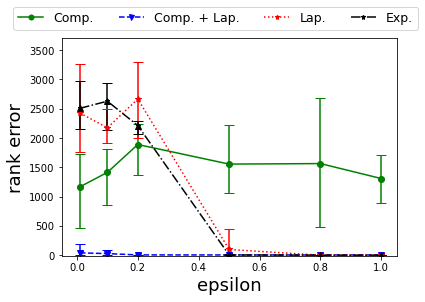

In [14]:
eta = 10
s = 10

n = int(2**(np.ceil(math.log2(M))))
k = int(np.floor(s*math.log(n/s)))

d = np.zeros(n)
for i in range(M):
    d[i] = stats[i]
    
psi = HaarMatrix(n)
ss = determineS(n,d,psi,eta)
kk = int(np.floor(ss*math.log(n/ss)))
    
phiphi = BernoulliMatrix(kk,n)
AA = np.dot(phiphi, psi)

phi = BernoulliMatrix(k,n)
A = np.dot(phi, psi)

K = 1

RE = np.zeros((6,4))
max_RE = np.zeros((6,4))
min_RE = np.ones((6,4)) * 10000
sum_RE = np.zeros((6,4))

epsilon = [0.01, 0.1, 0.2, 0.5, 0.8, 1.0]

for j in range(5):
    for i in range(6):
        RE[i] = RankError(stats, 4*N/(N+2), K, epsilon[i], eta, s, M, phi, phiphi, psi, A, AA, ss, k, kk)
        
        if RE[i][0] > max_RE[i][0]:
            max_RE[i][0] = RE[i][0]
        if RE[i][0] < min_RE[i][0]:
            min_RE[i][0] = RE[i][0]
        if RE[i][1] > max_RE[i][1]:
            max_RE[i][1] = RE[i][1]
        if RE[i][1] < min_RE[i][1]:
            min_RE[i][1] = RE[i][1]
        if RE[i][2] > max_RE[i][2]:
            max_RE[i][2] = RE[i][2]
        if RE[i][2] < min_RE[i][2]:
            min_RE[i][2] = RE[i][2]
        if RE[i][3] > max_RE[i][3]:
            max_RE[i][3] = RE[i][3]
        if RE[i][3] < min_RE[i][3]:
            min_RE[i][3] = RE[i][3]
        sum_RE[i][0] += RE[i][0]
        sum_RE[i][1] += RE[i][1]
        sum_RE[i][2] += RE[i][2]
        sum_RE[i][3] += RE[i][3]
    print(RE)

RE = sum_RE / 5

y_err = np.zeros((2,6,4))

y_err[0,:,0] = RE[:,0] - min_RE[:,0]
y_err[1,:,0] = max_RE[:,0] - RE[:,0]
y_err[0,:,1] = RE[:,1] - min_RE[:,1]
y_err[1,:,1] = max_RE[:,1] - RE[:,1]
y_err[0,:,2] = RE[:,2] - min_RE[:,2]
y_err[1,:,2] = max_RE[:,2] - RE[:,2]
y_err[0,:,3] = RE[:,3] - min_RE[:,3]
y_err[1,:,3] = max_RE[:,3] - RE[:,3]

fig = plt.figure()
plt.ylim(-10, 3700)
plt.xlim(-0.05, 1.05)
plt.errorbar(epsilon, RE[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, RE[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Comp.")
plt.errorbar(epsilon, RE[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, RE[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Comp. + Lap.")
plt.errorbar(epsilon, RE[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, RE[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Lap.")
plt.errorbar(epsilon, RE[:,3], yerr = y_err[:,:,3], capsize=5, fmt='^', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, RE[:,3], marker="*", markersize=5, color = "black", linestyle = "dashdot", label = "Exp.")
plt.legend(bbox_to_anchor=(0.46, 1.04), loc='lower center', borderaxespad=0, ncol=4, fontsize=12.5)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("rank error", fontsize = 18)
fig.savefig("RE_large_K=1.png")
fig.savefig("fig/RE_large_K=1.eps")

[[1790.26666667  126.83333333 2957.9        2804.46666667]
 [1593.86666667  103.6        2482.8        2474.46666667]
 [1761.8         156.46666667 2757.4        2022.9       ]
 [1230.5         147.         2419.96666667 1903.2       ]
 [1955.93333333    3.6        1951.93333333 2197.36666667]
 [1913.96666667    4.36666667 1441.9        1345.86666667]]
[[1880.06666667  217.86666667 2347.7        2366.4       ]
 [1840.66666667  347.06666667 2525.6        2994.06666667]
 [1913.46666667   74.53333333 2128.         2334.33333333]
 [1435.7          55.76666667 2343.93333333 2334.73333333]
 [1188.4           4.16666667 2087.         1689.        ]
 [ 962.36666667    4.1        1658.1        1220.76666667]]
[[1079.06666667  124.83333333 2534.46666667 2739.46666667]
 [1238.06666667  212.23333333 2649.7        2427.93333333]
 [1572.16666667    3.16666667 2705.2        2789.13333333]
 [1333.93333333  237.8        2020.73333333 2586.7       ]
 [2067.96666667  128.56666667 2083.03333333 2046.76666

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[1235.23333333  361.83333333 2560.23333333 3265.66666667]
 [1847.96666667  412.1        2265.53333333 2307.76666667]
 [1528.06666667  108.26666667 2165.83333333 2093.4       ]
 [1675.16666667  160.4        2110.4        2513.56666667]
 [2352.8         178.33333333 2281.         1656.4       ]
 [1163.            3.66666667 1361.03333333 1502.06666667]]


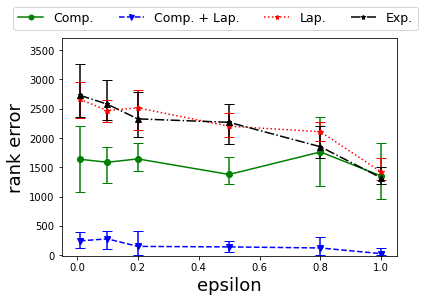

In [15]:
eta = 10
s = 10

K = 3

RE = np.zeros((6,4))
max_RE = np.zeros((6,4))
min_RE = np.ones((6,4)) * 10000
sum_RE = np.zeros((6,4))

epsilon = [0.01, 0.1, 0.2, 0.5, 0.8, 1.0]

for j in range(5):
    for i in range(6):
        RE[i] = RankError(stats, 4*N/(N+2), K, epsilon[i], eta, s, M, phi, phiphi, psi, A, AA, ss, k, kk)
        
        if RE[i][0] > max_RE[i][0]:
            max_RE[i][0] = RE[i][0]
        if RE[i][0] < min_RE[i][0]:
            min_RE[i][0] = RE[i][0]
        if RE[i][1] > max_RE[i][1]:
            max_RE[i][1] = RE[i][1]
        if RE[i][1] < min_RE[i][1]:
            min_RE[i][1] = RE[i][1]
        if RE[i][2] > max_RE[i][2]:
            max_RE[i][2] = RE[i][2]
        if RE[i][2] < min_RE[i][2]:
            min_RE[i][2] = RE[i][2]
        if RE[i][3] > max_RE[i][3]:
            max_RE[i][3] = RE[i][3]
        if RE[i][3] < min_RE[i][3]:
            min_RE[i][3] = RE[i][3]
        sum_RE[i][0] += RE[i][0]
        sum_RE[i][1] += RE[i][1]
        sum_RE[i][2] += RE[i][2]
        sum_RE[i][3] += RE[i][3]
    print(RE)

RE = sum_RE / 5

y_err = np.zeros((2,6,4))

y_err[0,:,0] = RE[:,0] - min_RE[:,0]
y_err[1,:,0] = max_RE[:,0] - RE[:,0]
y_err[0,:,1] = RE[:,1] - min_RE[:,1]
y_err[1,:,1] = max_RE[:,1] - RE[:,1]
y_err[0,:,2] = RE[:,2] - min_RE[:,2]
y_err[1,:,2] = max_RE[:,2] - RE[:,2]
y_err[0,:,3] = RE[:,3] - min_RE[:,3]
y_err[1,:,3] = max_RE[:,3] - RE[:,3]

fig = plt.figure()
plt.ylim(-10, 3700)
plt.xlim(-0.05, 1.05)
plt.errorbar(epsilon, RE[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, RE[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Comp.")
plt.errorbar(epsilon, RE[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, RE[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Comp. + Lap.")
plt.errorbar(epsilon, RE[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, RE[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Lap.")
plt.errorbar(epsilon, RE[:,3], yerr = y_err[:,:,3], capsize=5, fmt='^', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, RE[:,3], marker="*", markersize=5, color = "black", linestyle = "dashdot", label = "Exp.")
plt.legend(bbox_to_anchor=(0.46, 1.04), loc='lower center', borderaxespad=0, ncol=4, fontsize=12.5)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("rank error", fontsize = 18)
fig.savefig("RE_large_K=3.png")
fig.savefig("fig/RE_large_K=3.eps")

[[1572.1  1136.   2757.28 2172.04]
 [1882.94   69.34 2599.92 2645.58]
 [1419.12  433.84 2521.46 2515.8 ]
 [1428.4   748.06 2551.44 2647.58]
 [1515.1   351.4  2516.88 2042.94]
 [1599.    414.1  2259.58 2563.88]]
[[1512.16  360.42 2515.74 2439.48]
 [1448.06 1084.08 2161.08 2272.02]
 [1574.78  636.68 2736.52 2093.3 ]
 [1840.2   518.64 1951.86 2415.48]
 [1947.22  392.64 2067.18 2100.84]
 [1934.74  463.82 2153.22 2252.12]]
[[1605.76  638.48 2535.18 2864.26]
 [1393.24  824.36 2455.72 2435.58]
 [1565.34  515.54 2148.04 2093.3 ]
 [1866.32  728.48 2159.36 2407.5 ]
 [1704.02  578.62 2389.26 2096.32]
 [1694.26  710.2  2068.22 2255.48]]
[[1680.96  365.96 2567.56 2479.3 ]
 [2089.52  596.04 2563.2  2513.36]
 [1228.04  480.76 2734.98 2482.4 ]
 [1534.52  444.92 2262.88 2449.02]
 [1554.34  562.18 2035.32 2707.16]
 [1788.08  569.02 2464.44 2211.72]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[1679.7   789.48 2355.82 2516.18]
 [1510.28  512.44 2063.2  2427.52]
 [1470.52  231.76 2500.62 2376.26]
 [1480.46  909.58 2616.86 2141.1 ]
 [1916.3   612.46 2176.04 2096.1 ]
 [1603.    706.46 2330.34 2214.9 ]]


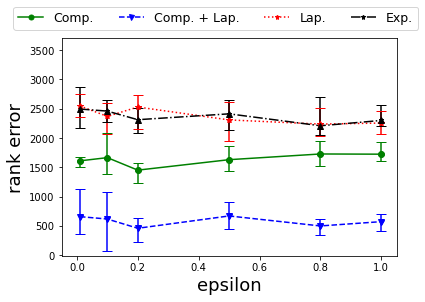

In [16]:
eta = 10
s = 10

K = 5

RE = np.zeros((6,4))
max_RE = np.zeros((6,4))
min_RE = np.ones((6,4)) * 10000
sum_RE = np.zeros((6,4))

epsilon = [0.01, 0.1, 0.2, 0.5, 0.8, 1.0]

for j in range(5):
    for i in range(6):
        RE[i] = RankError(stats, 4*N/(N+2), K, epsilon[i], eta, s, M, phi, phiphi, psi, A, AA, ss, k, kk)
        
        if RE[i][0] > max_RE[i][0]:
            max_RE[i][0] = RE[i][0]
        if RE[i][0] < min_RE[i][0]:
            min_RE[i][0] = RE[i][0]
        if RE[i][1] > max_RE[i][1]:
            max_RE[i][1] = RE[i][1]
        if RE[i][1] < min_RE[i][1]:
            min_RE[i][1] = RE[i][1]
        if RE[i][2] > max_RE[i][2]:
            max_RE[i][2] = RE[i][2]
        if RE[i][2] < min_RE[i][2]:
            min_RE[i][2] = RE[i][2]
        if RE[i][3] > max_RE[i][3]:
            max_RE[i][3] = RE[i][3]
        if RE[i][3] < min_RE[i][3]:
            min_RE[i][3] = RE[i][3]
        sum_RE[i][0] += RE[i][0]
        sum_RE[i][1] += RE[i][1]
        sum_RE[i][2] += RE[i][2]
        sum_RE[i][3] += RE[i][3]
    print(RE)

RE = sum_RE / 5

y_err = np.zeros((2,6,4))

y_err[0,:,0] = RE[:,0] - min_RE[:,0]
y_err[1,:,0] = max_RE[:,0] - RE[:,0]
y_err[0,:,1] = RE[:,1] - min_RE[:,1]
y_err[1,:,1] = max_RE[:,1] - RE[:,1]
y_err[0,:,2] = RE[:,2] - min_RE[:,2]
y_err[1,:,2] = max_RE[:,2] - RE[:,2]
y_err[0,:,3] = RE[:,3] - min_RE[:,3]
y_err[1,:,3] = max_RE[:,3] - RE[:,3]

fig = plt.figure()
plt.ylim(-10, 3700)
plt.xlim(-0.05, 1.05)
plt.errorbar(epsilon, RE[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, RE[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Comp.")
plt.errorbar(epsilon, RE[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, RE[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Comp. + Lap.")
plt.errorbar(epsilon, RE[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, RE[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Lap.")
plt.errorbar(epsilon, RE[:,3], yerr = y_err[:,:,3], capsize=5, fmt='^', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, RE[:,3], marker="*", markersize=5, color = "black", linestyle = "dashdot", label = "Exp.")
plt.legend(bbox_to_anchor=(0.46, 1.04), loc='lower center', borderaxespad=0, ncol=4, fontsize=12.5)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("rank error", fontsize = 18)
fig.savefig("RE_large_K=5.png")
fig.savefig("fig/RE_large_K=5.eps")

[[1930.41 1300.89 2397.88 2474.6 ]
 [1875.61 1485.1  2548.05 2498.43]
 [1762.14 1462.56 2626.28 2611.55]
 [1703.67 1407.74 2398.76 2562.03]
 [1571.33 1379.33 2414.11 2161.86]
 [1506.11 1573.24 2559.48 2382.77]]
[[1620.94 1557.7  2391.68 2362.29]
 [1779.76 1608.2  2336.7  2549.68]
 [1689.63 1293.13 2487.15 2344.73]
 [1921.22 1539.41 2643.17 2573.79]
 [1723.86 1590.85 2531.49 2465.26]
 [1724.69 1369.34 2311.33 2516.13]]
[[1803.58 1301.67 2347.52 2244.6 ]
 [1581.91 1312.5  2525.18 2580.93]
 [1542.06 1356.68 2521.3  2488.2 ]
 [1818.07 1377.19 2430.31 2408.45]
 [1728.22 1129.3  2356.35 2440.6 ]
 [1747.2  1374.7  2429.36 2411.6 ]]
[[1662.29 1632.71 2455.72 2272.37]
 [1595.3  1414.53 2343.02 2724.31]
 [1501.26 1302.26 2797.2  2489.59]
 [1885.59 1372.24 2086.11 2320.6 ]
 [1724.24 1512.04 2294.81 2441.16]
 [1765.16 1073.86 2410.22 2230.84]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[1580.52 1422.37 2464.2  2468.03]
 [1779.32 1620.68 2245.82 2535.17]
 [1762.6  1401.42 2538.74 2585.57]
 [2122.65 1242.5  2560.99 2302.61]
 [1774.37 1650.61 2590.2  2377.31]
 [1719.93 1220.14 2363.53 2197.45]]


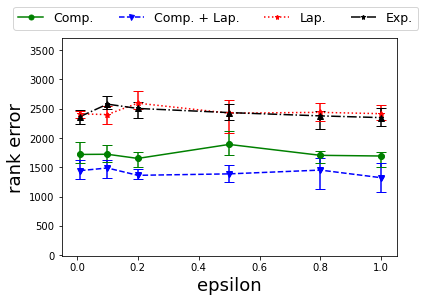

In [17]:
eta = 10
s = 10

K = 10

RE = np.zeros((6,4))
max_RE = np.zeros((6,4))
min_RE = np.ones((6,4)) * 10000
sum_RE = np.zeros((6,4))

epsilon = [0.01, 0.1, 0.2, 0.5, 0.8, 1.0]

for j in range(5):
    for i in range(6):
        RE[i] = RankError(stats, 4*N/(N+2), K, epsilon[i], eta, s, M, phi, phiphi, psi, A, AA, ss, k, kk)
        
        if RE[i][0] > max_RE[i][0]:
            max_RE[i][0] = RE[i][0]
        if RE[i][0] < min_RE[i][0]:
            min_RE[i][0] = RE[i][0]
        if RE[i][1] > max_RE[i][1]:
            max_RE[i][1] = RE[i][1]
        if RE[i][1] < min_RE[i][1]:
            min_RE[i][1] = RE[i][1]
        if RE[i][2] > max_RE[i][2]:
            max_RE[i][2] = RE[i][2]
        if RE[i][2] < min_RE[i][2]:
            min_RE[i][2] = RE[i][2]
        if RE[i][3] > max_RE[i][3]:
            max_RE[i][3] = RE[i][3]
        if RE[i][3] < min_RE[i][3]:
            min_RE[i][3] = RE[i][3]
        sum_RE[i][0] += RE[i][0]
        sum_RE[i][1] += RE[i][1]
        sum_RE[i][2] += RE[i][2]
        sum_RE[i][3] += RE[i][3]
    print(RE)

RE = sum_RE / 5

y_err = np.zeros((2,6,4))

y_err[0,:,0] = RE[:,0] - min_RE[:,0]
y_err[1,:,0] = max_RE[:,0] - RE[:,0]
y_err[0,:,1] = RE[:,1] - min_RE[:,1]
y_err[1,:,1] = max_RE[:,1] - RE[:,1]
y_err[0,:,2] = RE[:,2] - min_RE[:,2]
y_err[1,:,2] = max_RE[:,2] - RE[:,2]
y_err[0,:,3] = RE[:,3] - min_RE[:,3]
y_err[1,:,3] = max_RE[:,3] - RE[:,3]

fig = plt.figure()
plt.ylim(-10, 3700)
plt.xlim(-0.05, 1.05)
plt.errorbar(epsilon, RE[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, RE[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Comp.")
plt.errorbar(epsilon, RE[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, RE[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Comp. + Lap.")
plt.errorbar(epsilon, RE[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, RE[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Lap.")
plt.errorbar(epsilon, RE[:,3], yerr = y_err[:,:,3], capsize=5, fmt='^', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, RE[:,3], marker="*", markersize=5, color = "black", linestyle = "dashdot", label = "Exp.")
plt.legend(bbox_to_anchor=(0.46, 1.04), loc='lower center', borderaxespad=0, ncol=4, fontsize=12.5)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("rank error", fontsize = 18)
fig.savefig("RE_large_K=10.png")
fig.savefig("fig/RE_large_K=10.eps")